In [1]:

import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier 

import sklearn.metrics 

import matplotlib.pyplot as plt

def roc_auc(pred, act, plot=True, label = "curve"):
    prob = pred/pred.max() #normalize
    fpr, tpr, threshold = sklearn.metrics.roc_curve(act, prob, drop_intermediate=True)    
    auc = sklearn.metrics.auc(fpr, tpr)

    if plot:
        plt.scatter(x=fpr, y=tpr, color='navy')
        rcolor = tuple(np.random.rand(3,1)[:,0])
        plt.plot(fpr, tpr, c=rcolor, lw=2, label=label + ' (AUC = %0.3f)' % auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.show()

    return auc

### kaggle
datain_dir = './'
datain_col_dir = './'
dataout_dir = ''

### mac
#datain_dir = '~/Data/diabetes/'
#datain_col_dir = '~/Data/diabetes/'
#dataout_dir = '~/Data/diabetes/'

### desktop
#from kaggle import proj #desktop
#datain_dir = proj.data_dir #desktop

In [5]:
import azureml.core
import os
from azureml.core import Workspace

subscription_id = os.getenv("SUBSCRIPTION_ID", default="a6c2a7cc-d67e-4a1a-b765-983f08c0423a")
resource_group = os.getenv("RESOURCE_GROUP", default="xiaoyzhu-mlworkspace")
workspace_name = os.getenv("WORKSPACE_NAME", default="xiaoyzhu-MLworkspace")
workspace_region = os.getenv("WORKSPACE_REGION", default="eastus2")


try:
    ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
    # write the details of the workspace to a configuration file to the notebook library
    ws.write_config(file_name="xiaoyzhuconfig.json")
    print("Workspace configuration succeeded. Skip the workspace creation steps below")
except:
    print("Workspace not accessible. Change your parameters or create a new workspace below")

Wrote the config file xiaoyzhuconfig.json to: F:\PatientHub\MLModels\Diabetes\aml_config\xiaoyzhuconfig.json
Workspace configuration succeeded. Skip the workspace creation steps below


In [2]:
import numpy as np

# Read in the data

In [3]:
df_raw_all = pd.read_csv(datain_dir + 'diabetic_data.csv') 
df_raw = df_raw_all.sample(10000)
df_raw = df_raw.replace('?', np.nan) 
df_raw.shape

(10000, 50)

# How many values are missing in patient records?

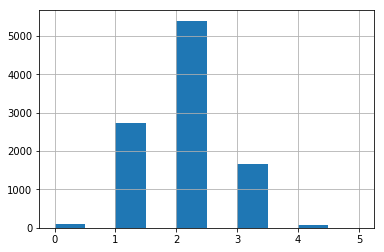

In [4]:
pt_sparsity = df_raw.isnull().apply(sum, axis=1)
%matplotlib inline
myhist = pt_sparsity.hist()

No need to drop patients due to missing values. 3 out of 50 missing values is not bad at all.

# Explore the variables, compile information about them

In [5]:
col_data = df_raw.apply(lambda s: set(s.unique()), axis=0).to_frame('uni_val')
col_data['nan_rat'] = df_raw.isnull().sum(axis=0)/len(df_raw)
col_data['n_uni_vals'] = col_data.uni_val.apply(len)
col_data['uni_vals_str'] = col_data[col_data.n_uni_vals<2000].uni_val.astype(str)
col_data = col_data.drop('uni_val', axis=1)
col_data['var_type'] = np.nan
col_data.to_csv(dataout_dir + "columns_raw.csv")

# Manual annotation of columns
I manually took columns_raw.csv and annotated columns based on whether they were ordered or categorical.  I saved my annotated file as columns.csv.  I will read this in later in the notebook.

In [6]:
col_data = pd.read_csv(datain_col_dir + "columns.csv", index_col=0)
col_data.sample(10)

,nan_rat,n_uni_vals,uni_vals_str,var_type,comment
readmitted,0.0000,3,"{'>30', '<30', 'NO'}",cat,NaN
metformin-pioglitazone,0.0000,1,{'No'},drop,no information here!
glipizide-metformin,0.0000,1,{'No'},drop,no information here!
glipizide,0.0000,4,"{'Steady', 'Up', 'No', 'Down'}",cat,NaN
glyburide-metformin,0.0000,3,"{'Steady', 'Up', 'No'}",cat,NaN
num_lab_procedures,0.0000,102,"{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",cont,NaN
payer_code,0.3962,17,"{nan, 'HM', 'OG', 'MC', 'DM', 'CM', 'SI', 'MD'...",cat,NaN
medical_specialty,0.4941,55,"{nan, 'Surgery-Plastic', 'Pulmonology', 'Osteo...",drop,eventually we will include top specialties
diag_2,0.0046,446,"{nan, '644', '907', '568', '356', '225', 'V69'...",drop,eventually we will include top diagnoses
discharge_disposition_id,0.0000,21,"{1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 13, 14, 15, 17...",cat,NaN


# Generate boolean features for only most common medical specialties

In [7]:
#TODO recapture medical specialty
spec_counts = df_raw.medical_specialty.value_counts()
spec_counts.head(5).to_frame('num patients')

,num patients
InternalMedicine,1454
Family/GeneralPractice,799
Emergency/Trauma,758
Cardiology,519
Surgery-General,305


In [8]:
spec_thresh = 5
for (spec, count) in spec_counts.head(spec_thresh).iteritems():
    new_col = 'spec_' + str(spec)
    df_raw[new_col] = (df_raw.medical_specialty == spec)
    
df_raw.filter(regex='spec').sample(10)

,medical_specialty,spec_InternalMedicine,spec_Family/GeneralPractice,spec_Emergency/Trauma,spec_Cardiology,spec_Surgery-General
95451,NaN,False,False,False,False,False
3312,Cardiology,False,False,False,True,False
11304,Family/GeneralPractice,False,True,False,False,False
11736,NaN,False,False,False,False,False
21665,InternalMedicine,True,False,False,False,False
53369,NaN,False,False,False,False,False
63905,Surgery-Neuro,False,False,False,False,False
61186,Cardiology,False,False,False,True,False
66969,NaN,False,False,False,False,False
14164,NaN,False,False,False,False,False


# Identify the most common diagnoses

In [9]:
diag_counts = (df_raw.diag_1.value_counts() + df_raw.diag_2.value_counts() + df_raw.diag_3.value_counts()).sort_values(ascending=False)
diag_counts.head(10).to_frame('num patients w diag')

,num patients w diag
250,1715.0
428,1706.0
276,1417.0
414,1256.0
401,1176.0
427,1162.0
599,651.0
496,602.0
486,559.0
403,519.0


# Generate boolean features for top N diagnoses

In [10]:
diag_thresh = 10
for (icd9, count) in diag_counts.head(diag_thresh).iteritems():
    new_col = 'diag_' + str(icd9)
    df_raw[new_col] = (df_raw.diag_1 == icd9)|(df_raw.diag_2 == icd9)|(df_raw.diag_3 == icd9)
    
df_raw.filter(regex='diag_').sample(10)

,diag_1,diag_2,diag_3,diag_250,diag_428,diag_276,diag_414,diag_401,diag_427,diag_599,diag_496,diag_486,diag_403
92614,786,250.92,401,False,False,False,False,True,False,False,False,False,False
49806,79,250.01,V42,False,False,False,False,False,False,False,False,False,False
32302,414,786,250,True,False,False,True,False,False,False,False,False,False
65945,491,518,428,False,True,False,False,False,False,False,False,False,False
8887,250.8,276,244,False,False,True,False,False,False,False,False,False,False
49164,428,401,250,True,True,False,False,True,False,False,False,False,False
15245,427,428,426,False,True,False,False,False,True,False,False,False,False
10669,821,428,426,False,True,False,False,False,False,False,False,False,False
18678,682,250,780,True,False,False,False,False,False,False,False,False,False
36816,428,276,493,False,True,True,False,False,False,False,False,False,False


# Clean the data

In [11]:
df_raw.age.sample(10)

42178     [70-80)
43665     [70-80)
78630     [40-50)
47717     [80-90)
17912    [90-100)
20810     [60-70)
42029     [60-70)
64909     [40-50)
3964      [30-40)
11925     [60-70)
Name: age, dtype: object

In [12]:
df_raw2 = pd.DataFrame(df_raw, copy=True) #preserve df_raw so I can rerun this step
df_raw2['age'] = df_raw2.age.str.extract('(\d+)-\d+')

to_drop = col_data[col_data.var_type.str.contains('drop')].index
df_raw2.drop(to_drop, axis=1, inplace=True)

#break out categorical variables into binaries
cat_cols = col_data[col_data.var_type.str.contains('cat')].index
df_raw2 = pd.get_dummies(df_raw2, columns=cat_cols)

#dropping these leaves up with one binary variable, ideal for simplicity
df_raw2.drop(['readmitted_<30','readmitted_>30'], axis=1, inplace=True)

#cleaning up outcome variable
df_raw2['is_readmitted'] = (df_raw2.readmitted_NO == 0)
df_raw2.drop('readmitted_NO', axis=1, inplace=True)

#ta daaaaaah, the data is ready to go
df = pd.DataFrame(df_raw2)
df.shape

(10000, 156)

In [13]:
df.age.sample(10)

98617    80
69661    60
16808    40
15984    20
6994     70
8887     70
31069    80
11446    80
26238    50
54831    60
Name: age, dtype: object

In [14]:
df.sample(15).sample(7, axis=1)

,glyburide_Down,A1Cresult_>8,time_in_hospital,discharge_disposition_id_2,change_No,admission_source_id_8,number_inpatient
97090,0,0,5,0,0,0,0
79433,0,0,14,0,1,0,1
8517,0,0,4,0,1,0,0
71720,0,0,2,0,0,0,0
73675,0,0,4,0,1,0,2
11493,0,0,2,0,0,0,0
28668,0,0,2,0,0,0,0
71617,0,0,3,0,0,0,0
2787,0,0,14,0,1,0,0
52619,0,0,4,0,1,0,0


# Examine outcome variable

In [15]:
df.is_readmitted.value_counts()

False    5346
True     4654
Name: is_readmitted, dtype: int64

# Define this machine learning problem, impute, set aside test data

In [16]:
#partition training and test data, one balanced training set, all remaining for testing 
outcome_column = 'is_readmitted' 

#Imputing with outlying value since we are focusing on tree based methods
dff = df.fillna(-9999) 

#%% Split data for validation
X = dff.drop(outcome_column, axis=1) 
y = dff[outcome_column] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0) 

# Fit data to Random Forest model, trying different subsets of variables


In [17]:
rfc_rfe = RandomForestClassifier(n_estimators = 100)
#This step takes a while to run...
rfe = RFECV(estimator=rfc_rfe, cv=5, verbose=0, n_jobs=10)
rfe.fit(X_train, y_train)

RFECV(cv=5,
   estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
   min_features_to_select=1, n_jobs=10, scoring=None, step=1, verbose=0)

# Examine feature importances

In [18]:
feat_ranks = pd.Series(index=X.columns, data=rfe.ranking_)
rf_feats = feat_ranks[feat_ranks==1].index
len(feat_ranks)

155

In [19]:
len(rf_feats)

132

In [20]:
X_test_red = rfe.transform(X_test)
X_train_red = rfe.transform(X_train)

rfc = rfe.estimator_

feat_imp = pd.Series(index=rf_feats, data=rfc.feature_importances_)
feat_imp.sort_values(ascending=False).head(20)

num_lab_procedures            0.077656
num_medications               0.072497
time_in_hospital              0.054118
number_inpatient              0.048967
age                           0.045857
number_diagnoses              0.040058
num_procedures                0.036495
number_outpatient             0.021807
number_emergency              0.017384
discharge_disposition_id_1    0.015114
payer_code_MC                 0.014983
gender_Male                   0.013913
gender_Female                 0.013432
race_Caucasian                0.012529
diag_428                      0.012299
admission_source_id_7         0.011662
diag_276                      0.011526
insulin_Steady                0.011403
diag_427                      0.011262
diag_250                      0.011148
dtype: float64

# Assess prediction accuracy

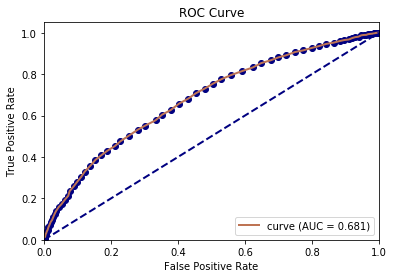

0.6808604823132954

In [21]:
#%% assess accuracy
pred = rfc.predict_proba(X_test_red)[:,1]
fpr, tpr, threshold = sklearn.metrics.roc_curve(y_test, pred, drop_intermediate=True)    
df_res = pd.DataFrame(data={'fpr':fpr, 'tpr':tpr, 'threshold':threshold})
df_res = df_res[['threshold','fpr','tpr']]
sklearn.metrics.auc(fpr, tpr)
t=y.value_counts()[1]/y.value_counts().sum()
sklearn.metrics.f1_score(y_test, pred>t)
sklearn.metrics.accuracy_score(y_test, pred>t)

roc_auc(pred, y_test)

In [22]:
#TODO - visualize accuracy metrics based on threshold
pd.options.mode.chained_assignment = None
pred = rfc.predict_proba(X_test_red)[:,1]
fpr, tpr, threshold = sklearn.metrics.roc_curve(y_test, pred, drop_intermediate=True)    
df_res = pd.DataFrame(data={'fpr':fpr, 'tpr':tpr, 'threshold':threshold})
df_res = df_res[['threshold','fpr','tpr']]
sklearn.metrics.auc(fpr, tpr)

0.6808604823132954

In [23]:
df_res['accuracy'] = df_res.threshold.apply(lambda t: sklearn.metrics.accuracy_score(y_test, pred>t))
df_res['precision'] = df_res.threshold.apply(lambda t: sklearn.metrics.precision_score(y_test, pred>t))
df_res['recall'] = df_res.threshold.apply(lambda t: sklearn.metrics.recall_score(y_test, pred>t))
df_res['f1'] = df_res.threshold.apply(lambda t: sklearn.metrics.f1_score(y_test, pred>t))
df_res['specificity'] = df_res.fpr.apply(lambda fpr: 1-fpr)

pt_opt = df_res[df_res.f1 == df_res.f1.max()].iloc[0]
pt_opt

C:\Users\xiaoyzhu.REDMOND\AppData\Local\Continuum\anaconda3\envs\azureml\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\xiaoyzhu.REDMOND\AppData\Local\Continuum\anaconda3\envs\azureml\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold      0.360000
fpr            0.677419
tpr            0.867130
accuracy       0.582600
precision      0.529079
recall         0.853235
f1             0.653149
specificity    0.322581
Name: 55, dtype: float64

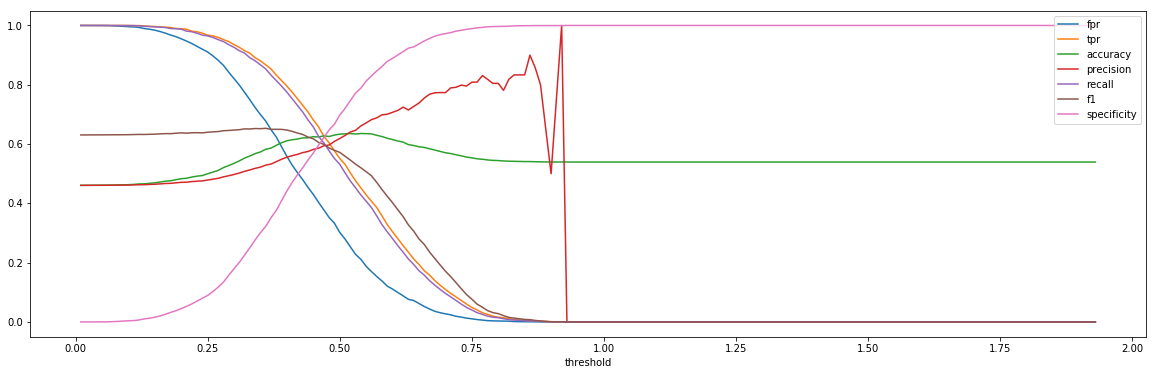

In [24]:
plt.rcParams["figure.figsize"] = (20,6)
df_res.plot(x='threshold')

# Generate Decision tree based on the top features

In [25]:
from sklearn.externals.six import StringIO  

dtc = DecisionTreeClassifier(min_samples_leaf=0.125, min_samples_split=0.125)
dtc.fit(X_train_red, y_train)
from sklearn import tree


In [26]:
from IPython.display import Image
from subprocess import check_call
tree.export_graphviz(dtc, out_file="tree.dot", feature_names=rf_feats, proportion=True)
check_call(['dot','-Tpng','tree.dot','-o','tree.png'])
Image(filename='tree.png')

FileNotFoundError: [WinError 2] The system cannot find the file specified